<a href="https://colab.research.google.com/github/s10114618/Autoencoder-for-Anomaly-Detection-on-AWS-network-log-with-Model-Evaluation/blob/master/Autoencoder_for_Anomaly_Detection_on_AWS_network_log_with_model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import glob
import os
import seaborn as sns
from sklearn import preprocessing
from pylab import rcParams
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from sklearn.model_selection import train_test_split
from google_drive_downloader import GoogleDriveDownloader as gdd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
# Download files from google drive
gdd.download_file_from_google_drive(file_id='1c6S3HgcfpQA9Hcu4q7R6F1xXIa1cEe8x',
                                    dest_path='./data/cse-cic-ids2018.csv',
                                    unzip=True)

Unzipping...

/usr/local/lib/python3.6/dist-packages/google_drive_downloader/google_drive_downloader.py:78: UserWarning: Ignoring `unzip` since "1c6S3HgcfpQA9Hcu4q7R6F1xXIa1cEe8x" does not look like a valid zip file
  warnings.warn('Ignoring `unzip` since "{}" does not look like a valid zip file'.format(file_id))


In [3]:
logs_directory = "/content/data"
# change current working directory
os.chdir(logs_directory)
# find all csv files in folder
pcap_files = glob.glob('*.{}'.format("csv"))
pcap_files

['cse-cic-ids2018.csv']

In [6]:
# concat multiple csv into one df
pcap_array = []
for csv in pcap_files:
    df = pd.read_csv(csv, index_col=None, header=0)
    pcap_array.append(df)
df = pd.concat(pcap_array)

In [7]:
df.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,15/02/2018 08:25:18,112641158,3,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.026633,56320579.00,7.042784e+02,56321077,56320081,112641158,5.632058e+07,7.042784e+02,56321077,56320081,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,0.026633,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0.0,0.000000,0.000000,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.000000,0,0,56320579.0,7.042784e+02,56321077,56320081,Benign
1,22,6,15/02/2018 08:29:05,37366762,14,12,2168,2993,712,0,154.857143,254.855270,976,0,249.416667,395.929392,138.117400,0.695806,1494670.48,3.894924e+06,15617415,7,37366762,2.874366e+06,5.104444e+06,15617415,40,37366730,3.396975e+06,5.564224e+06,15936762,893,0,0,0,0,456,416,0.374665,0.321141,0,976,191.148148,320.122898,102478.669516,0,0,0,1,0,0,0,0,0,198.5,154.857143,249.416667,0,0,0,0,0,0,14,2168,12,2993,29200,232,8,32,1024353.0,649038.754495,1601183,321569,11431221.0,3.644991e+06,15617415,8960247,Benign
2,47514,6,15/02/2018 08:29:42,543,2,0,64,0,64,0,32.000000,45.254834,0,0,0.000000,0.000000,117863.720074,3683.241252,543.00,0.000000e+00,543,543,543,5.430000e+02,0.000000e+00,543,543,0,0.000000e+00,0.000000e+00,0,0,1,0,0,0,64,0,3683.241252,0.000000,0,64,42.666667,36.950417,1365.333333,0,1,0,0,1,0,0,0,0,64.0,32.000000,0.000000,0,0,0,0,0,0,2,64,0,0,244,-1,0,32,0.0,0.000000,0,0,0.0,0.000000e+00,0,0,Benign
3,0,0,15/02/2018 08:28:07,112640703,3,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.026633,56320351.50,3.669884e+02,56320611,56320092,112640703,5.632035e+07,3.669884e+02,56320611,56320092,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,0.026633,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0.0,0.000000,0.000000,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.000000,0,0,56320351.5,3.669884e+02,56320611,56320092,Benign
4,0,0,15/02/2018 08:30:56,112640874,3,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.026633,56320437.00,7.198347e+02,56320946,56319928,112640874,5.632044e+07,7.198347e+02,56320946,56319928,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,0.026633,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0.0,0.000000,0.000000,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.000000,0,0,56320437.0,7.198347e+02,56320946,56319928,Benign


In [8]:
df.shape

(1048575, 80)

In [9]:
# Test on 2 type of classes.
df = df[ (df['Label'] == 'Benign') | (df['Label'] == 'DoS attacks-GoldenEye')].reset_index().drop(['index'], axis=1)

In [10]:
df['Label'].drop_duplicates()

0                    Benign
44    DoS attacks-GoldenEye
Name: Label, dtype: object

In [11]:
df.shape

(1037585, 80)

In [12]:
print(len(df[df['Label'] == 'Benign']))
print(len(df[df['Label'] == 'DoS attacks-GoldenEye']))
#print(len(df[df['Label'] == 'DoS attacks-Slowloris']))

996077
41508


In [13]:
## Some of the data contains na,inf and -inf. Set them to 0.
df['Flow Byts/s'].fillna(0, inplace=True)
df['Flow Byts/s'] = df['Flow Byts/s'].replace(np.inf, 0)
df['Flow Pkts/s'] = df['Flow Pkts/s'].replace(np.inf, 0)
df['Flow Byts/s'] = df['Flow Byts/s'].replace(-np.inf, 0)
df['Flow Pkts/s'] = df['Flow Pkts/s'].replace(-np.inf, 0)

In [14]:
## Remove non-numeric and normalise the data
x_col = ['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']
x = df[x_col]
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x.values)
x = pd.DataFrame(x_scaled, columns=x_col)
## Append back with non-numeric data after normalise
df = df[['Label']].join(x)

In [15]:
df.head()

,Label,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,Benign,0.000000,0.000000,0.938676,0.000222,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,6.658312e-09,0.469371,0.000008,0.469375,4.693672e-01,0.938677,0.469371,0.000008,0.469375,4.693672e-01,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,6.658312e-09,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000222,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.469371,0.000010,0.469375,0.469367
1,Benign,0.000336,0.352941,0.311390,0.001441,0.000626,0.000248,0.000107,0.011049,0.0,0.009369,0.013850,0.360414,0.0,0.171075,0.297834,1.063669e-07,1.739514e-07,0.012456,0.046197,0.130154,5.833745e-08,0.311390,0.023955,0.060487,0.130154,3.333569e-07,0.31139,0.028329,0.065847,0.132903,0.000007,0.0,0.0,0.0,0.0,0.002225,0.001084,9.366613e-08,1.605705e-07,0.0,0.015146,0.057454,0.030258,0.000916,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.059640,0.009369,0.171075,0.0,0.0,0.0,0.0,0.0,0.0,0.001441,0.000248,0.000626,0.000107,0.445572,0.003555,0.00545,0.571429,0.009147,0.010785,0.014297,0.002871,0.095267,0.050267,0.130154,0.074674
2,Benign,0.725028,0.352941,0.000005,0.000111,0.000000,0.000007,0.000000,0.000993,0.0,0.001936,0.002459,0.000000,0.0,0.000000,0.000000,9.076913e-05,9.208103e-04,0.000005,0.000000,0.000005,4.525320e-06,0.000005,0.000005,0.000000,0.000005,4.525320e-06,0.00000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.000312,0.000000,9.208103e-04,0.000000e+00,0.0,0.000993,0.012824,0.003493,0.000012,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.019229,0.001936,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000111,0.000007,0.000000,0.000000,0.003738,0.000000,0.00000,0.571429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Benign,0.000000,0.000000,0.938673,0.000222,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,6.658339e-09,0.469369,0.000004,0.469372,4.693673e-01,0.938673,0.469369,0.000004,0.469372,4.693673e-01,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,6.658339e-09,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000222,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.469369,0.000005,0.469372,0.469367
4,Benign,0.000000,0.000000,0.938674,0.000222,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,6.658329e-09,0.469370,0.000009,0.469374,4.693659e-01,0.938675,0.469370,0.000009,0.469374,4.693659e-01,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,6.658329e-09,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [16]:
## Extract the appropriate features for training
df = df[['URG Flag Cnt','SYN Flag Cnt','RST Flag Cnt','PSH Flag Cnt','Protocol', 'Pkt Size Avg','Flow Pkts/s','FIN Flag Cnt','ECE Flag Cnt','ACK Flag Cnt','Dst Port','Label']]

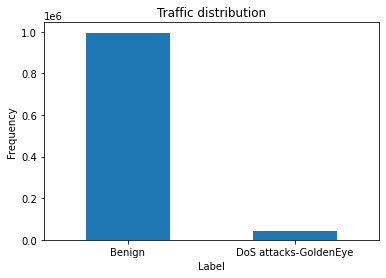

In [17]:
count_labels = pd.value_counts(df['Label'], sort = True)
count_labels.plot(kind = 'bar', rot=0)
plt.title("Traffic distribution")
plt.xlabel("Label")
plt.ylabel("Frequency");

In [18]:
# Encode categorical data into numeric 
label_encoder = LabelEncoder()
label_num = label_encoder.fit_transform(df['Label'])
df['Value'] = pd.Series(label_num)

In [19]:
print(df[df['Label'].str.contains("Benign")][0:1])
print(df[df['Label'].str.contains("GoldenEye")][0:1])
#print(df[df['Label'].str.contains("Slowloris")][0:1])

   URG Flag Cnt  SYN Flag Cnt  RST Flag Cnt  ...  Dst Port   Label  Value
0           0.0           0.0           0.0  ...       0.0  Benign      0

[1 rows x 13 columns]
    URG Flag Cnt  SYN Flag Cnt  ...                  Label  Value
44           0.0           0.0  ...  DoS attacks-GoldenEye      1

[1 rows x 13 columns]


In [20]:
df_normal = df[df['Label'] == 'Benign']
df_anomaly = df[df['Label'] != 'Benign']
print("Number of normal label: " + str(df_normal.shape))
print("Number of anomaly label: " + str(df_anomaly.shape))

Number of normal label: (996077, 13)
Number of anomaly label: (41508, 13)


In [21]:
df_normal.describe()

,URG Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,Protocol,Pkt Size Avg,Flow Pkts/s,FIN Flag Cnt,ECE Flag Cnt,ACK Flag Cnt,Dst Port,Value
count,996077.000000,996077.000000,996077.000000,996077.000000,996077.000000,996077.000000,996077.000000,996077.000000,996077.000000,996077.000000,996077.000000,996077.0
mean,0.050188,0.050355,0.064201,0.348394,0.570818,0.027866,0.010524,0.006050,0.064199,0.282343,0.118685,0.0
std,0.218333,0.218676,0.245111,0.476462,0.316365,0.037336,0.066099,0.077544,0.245107,0.450139,0.273329,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.352941,0.000000,0.000001,0.000000,0.000000,0.000000,0.000809,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.352941,0.021660,0.000029,0.000000,0.000000,0.000000,0.001221,0.0
75%,0.000000,0.000000,0.000000,1.000000,1.000000,0.033501,0.001639,0.000000,0.000000,1.000000,0.006790,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [22]:
df_anomaly.describe()

,URG Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,Protocol,Pkt Size Avg,Flow Pkts/s,FIN Flag Cnt,ECE Flag Cnt,ACK Flag Cnt,Dst Port,Value
count,41508.0,41508.000000,41508.0,41508.000000,4.150800e+04,41508.000000,4.150800e+04,41508.000000,41508.0,41508.000000,4.150800e+04,41508.0
mean,0.0,0.000024,0.0,0.647104,3.529412e-01,0.033158,2.182184e-06,0.000024,0.0,0.352896,1.220740e-03,1.0
std,0.0,0.004908,0.0,0.477876,2.180504e-13,0.024509,1.171016e-04,0.004908,0.0,0.477876,3.426120e-17,0.0
min,0.0,0.000000,0.0,0.000000,3.529412e-01,0.000000,5.811448e-09,0.000000,0.0,0.000000,1.220740e-03,1.0
25%,0.0,0.000000,0.0,0.000000,3.529412e-01,0.000000,1.674126e-07,0.000000,0.0,0.000000,1.220740e-03,1.0
50%,0.0,0.000000,0.0,1.000000,3.529412e-01,0.043866,2.599179e-07,0.000000,0.0,0.000000,1.220740e-03,1.0
75%,0.0,0.000000,0.0,1.000000,3.529412e-01,0.051603,3.979609e-07,0.000000,0.0,1.000000,1.220740e-03,1.0
max,0.0,1.000000,0.0,1.000000,3.529412e-01,0.140913,2.380952e-02,1.000000,0.0,1.000000,1.220740e-03,1.0


In [23]:
# Split Data into Train and Test
#data = df.drop(['Timestamp'], axis=1) #Some of the csv contains Timestamp field
data = df
# random state ensure that the train test split are deterministic
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

## Again Split Train data set into Train and Validation set. With 80% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train, X_train, test_size = 0.2, random_state = 12345)

# Train the data with only benign data
X_train = X_train[X_train['Label'] == 'Benign']
y_train = X_train['Value']
X_train = X_train.drop(['Label', 'Value'], axis=1)
X_train = X_train.values
y_val = y_train.values

# Validation data with benign n malicious data
y_val = X_val['Value']
X_val = X_val.drop(['Label', 'Value'], axis=1)
X_val = X_val.values
y_val = y_val.values

# Testing set
y_test = X_test['Value']
X_test = X_test.drop(['Label', 'Value'], axis=1)
X_test = X_test.values
y_test = y_test.values

In [24]:
print("Train dataset")
print(X_train.shape)
print(y_train.shape)

print("Val dataset")
print(X_val.shape)
print(y_val.shape)

print("Test dataset")
print(X_test.shape)
print(y_test.shape)

Train dataset
(637597, 11)
(637597,)
Val dataset
(166014, 11)
(166014,)
Test dataset
(207517, 11)
(207517,)


In [25]:
input_dim = X_train.shape[1] # No. of features
encoding_dim = 16
nb_epoch = 10
batch_size = 128
input_dim = X_train.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

1. Autoencoder is an unsupervised machine learning algorithm.

2. Autoencoders are similar to dimensionality reduction techniques like Principal Component Analysis (PCA).

3. Autoencoders project data from a higher dimension to a lower dimension using linear transformation and try to preserve the important features of the data while removing the non-essential parts.

4. Autoencoder can be broken in to three parts. Encoder, Bottleneck and Decoder.

> Encoder: In which the model learns how to reduce the input dimensions and compress the input data into an encoded representation.

> Bottleneck: which is the layer that contains the compressed representation of the input data. This is the lowest possible dimensions of the input data

> Decoder: In which the model learns how to reconstruct the data from the encoded representation to be as close to the original input as possible.

5. Reconstruction Loss: This is the method that measures measure how well the decoder is performing and how close the output is to the original input.
The training then involves using back propagation in order to minimize the network’s reconstruction loss.

> Aim of an autoencoder is to learn a representation (encoding) for a set of data, by training the network to ignore signal “noise”.








In [26]:
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error')
                    #,metrics=['accuracy']) #unsupervised method does not have accuracy.

# Save the best performance model
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)


history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_val, X_val),
                    verbose=1,
                    callbacks=[checkpointer]).history

Train on 637597 samples, validate on 166014 samples
Epoch 1/10
637597/637597 [==============================] - 24s 38us/step - loss: 0.0135 - val_loss: 0.0109
Epoch 2/10
637597/637597 [==============================] - 22s 35us/step - loss: 0.0112 - val_loss: 0.0107
Epoch 3/10
637597/637597 [==============================] - 22s 35us/step - loss: 0.0111 - val_loss: 0.0107
Epoch 4/10
637597/637597 [==============================] - 22s 35us/step - loss: 0.0111 - val_loss: 0.0107
Epoch 5/10
637597/637597 [==============================] - 22s 34us/step - loss: 0.0111 - val_loss: 0.0107
Epoch 6/10
637597/637597 [==============================] - 22s 34us/step - loss: 0.0111 - val_loss: 0.0107
Epoch 7/10
637597/637597 [==============================] - 22s 34us/step - loss: 0.0111 - val_loss: 0.0107
Epoch 8/10
637597/637597 [==============================] - 22s 34us/step - loss: 0.0110 - val_loss: 0.0105
Epoch 9/10
637597/637597 [==============================] - 22s 34us/step - loss: 0.

In [27]:
autoencoder = load_model('model.h5')

A loss function is used to optimize a machine learning algorithm. The loss is calculated on training and validation and its interpretation is based
on how well the model is doing in these two sets. It is the sum of errors made for each example in training or validation sets.
Loss value implies how poorly or well a model behaves after each iteration of optimization.
From the diagram, we can see that the loss, stabilises after each epoch.


If your training loss is much lower than validation loss then this means the network might be overfitting. Sol: Increase dropout.
Dropout has the effect of making the training process noisy, forcing nodes within a layer to probabilistically take on more or less responsibility for the inputs


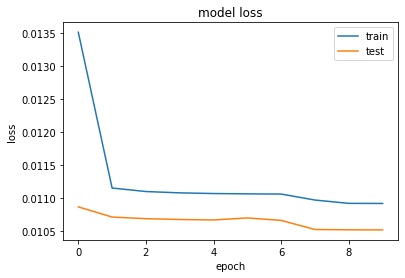

In [28]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
print("A loss function is used to optimize a machine learning algorithm. The loss is calculated on training and validation and its interpretation is based")
print("on how well the model is doing in these two sets. It is the sum of errors made for each example in training or validation sets.")
print("Loss value implies how poorly or well a model behaves after each iteration of optimization.")
print("From the diagram, we can see that the loss, stabilises after each epoch.")

print("\n\nIf your training loss is much lower than validation loss then this means the network might be overfitting. Sol: Increase dropout.")
print("Dropout has the effect of making the training process noisy, forcing nodes within a layer to probabilistically take on more or less responsibility for the inputs")

In [29]:
from IPython.display import Image
from IPython.core.display import HTML
print("Example of MSE\nPurple dots are the points on the graph. X and Y coordinate.")
print("Blue line is our prediction line.")
print("Red line between each purple point and the prediction line are the errors.")
print("The ideal MSE isn't 0, since then you would have a model that perfectly predicts your training data, but which is very unlikely to perfectly predict any other data.")
print("There are no acceptable limits for MSE except that the lower the MSE the higher the accuracy of prediction as there would be excellent match between the actual and predicted data set.")
print("So, if the standard deviation is 0.5, it basically means that on average the difference between mean and data points is 0.5.")
Image(url= "https://cdn-media-1.freecodecamp.org/images/MNskFmGPKuQfMLdmpkT-X7-8w2cJXulP3683")


Example of MSE
Purple dots are the points on the graph. X and Y coordinate.
Blue line is our prediction line.
Red line between each purple point and the prediction line are the errors.
The ideal MSE isn't 0, since then you would have a model that perfectly predicts your training data, but which is very unlikely to perfectly predict any other data.
There are no acceptable limits for MSE except that the lower the MSE the higher the accuracy of prediction as there would be excellent match between the actual and predicted data set.
So, if the standard deviation is 0.5, it basically means that on average the difference between mean and data points is 0.5.


In [30]:
# Predict test dataset
predictions = autoencoder.predict(X_test)
# Mean Square Error - measures the average of the squares of the errors
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
reconstruction_error = pd.DataFrame({'reconstruction_error': mse,'true_class': y_test})
reconstruction_error.describe()

,reconstruction_error,true_class
count,2.075170e+05,207517.000000
mean,1.039787e-02,0.040377
std,2.891522e-02,0.196843
min,2.138032e-09,0.000000
25%,4.246261e-07,0.000000
50%,1.311027e-06,0.000000
75%,5.478667e-06,0.000000
max,9.296475e-02,1.000000


In [31]:
print("The standard deviation (SD) measures the amount of variability, or dispersion, from the individual data values to the mean.")
print("From the output result above: count,min,25%,50%,75% and max are from the data.")
print("A smaller standard deviation indicates that more of the data is clustered about the mean while A larger one indicates the data are more spread out.")
print("Data might not be a normal distribution graph. The below image is just an illustration")
Image(url= "https://www.students4bestevidence.net/app/uploads/2018/09/Image-1-Standard-deviation-Standard-error--768x555.jpg")

The standard deviation (SD) measures the amount of variability, or dispersion, from the individual data values to the mean.
From the output result above: count,min,25%,50%,75% and max are from the data.
A smaller standard deviation indicates that more of the data is clustered about the mean while A larger one indicates the data are more spread out.
Data might not be a normal distribution graph. The below image is just an illustration


In [32]:
print("Reconstruction error is shown in this matrix of differences between original sample values and reconstructed sample values.")
reconstruction_error.head()

Reconstruction error is shown in this matrix of differences between original sample values and reconstructed sample values.


,reconstruction_error,true_class
0,2.055868e-07,0
1,2.050983e-07,0
2,3.367915e-06,0
3,9.091201e-02,0
4,7.876770e-07,0


In [33]:
print("A histogram displays numerical data by grouping data into bins of equal width.")
print("Each bin is plotted as a bar whose height corresponds to how many data points are in that bin. Bins are also sometimes called intervals, classes, or buckets.")
Image(url="https://statistics.laerd.com/statistical-guides/img/uh/laerd-statistics-example-histograms-showing-different-bin-sizes.png")

A histogram displays numerical data by grouping data into bins of equal width.
Each bin is plotted as a bar whose height corresponds to how many data points are in that bin. Bins are also sometimes called intervals, classes, or buckets.


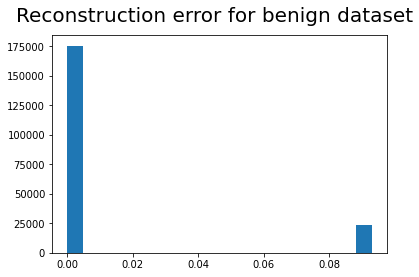

In [34]:
fig = plt.figure()
fig.suptitle('Reconstruction error for benign dataset', fontsize=20)
ax = fig.add_subplot(111)
normal_error_df = reconstruction_error[reconstruction_error['true_class'] == 0]
remove = ax.hist(normal_error_df.reconstruction_error.values, bins=20)

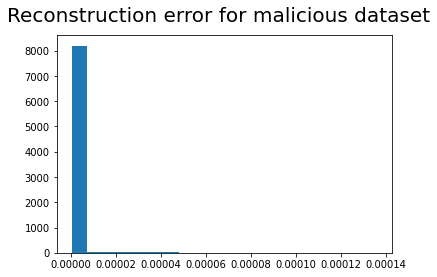

In [35]:
fig = plt.figure()
fig.suptitle('Reconstruction error for malicious dataset', fontsize=20)
ax = fig.add_subplot(111)
fraud_error_df = reconstruction_error[reconstruction_error['true_class'] == 1]
remove = ax.hist(fraud_error_df.reconstruction_error.values, bins=20)

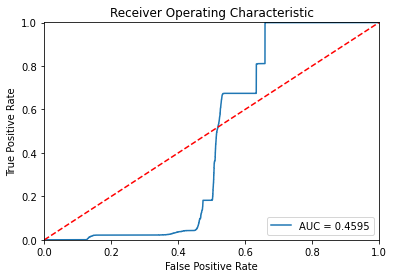

In [36]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(reconstruction_error.true_class, reconstruction_error.reconstruction_error)
roc_auc = auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [37]:
print("The ROC curve is plotted with TPR against the FPR.")
print("Higher the AUC(Area under curve), better the model is at predicting 0s as 0s and 1s as 1s.")
Image(url= "https://miro.medium.com/max/451/1*pk05QGzoWhCgRiiFbz-oKQ.png")

The ROC curve is plotted with TPR against the FPR.
Higher the AUC(Area under curve), better the model is at predicting 0s as 0s and 1s as 1s.


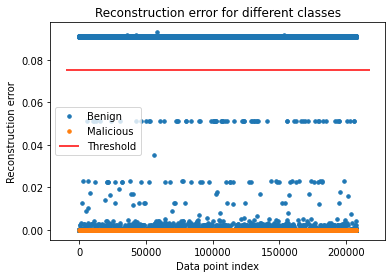

In [38]:
threshold = 0.075

groups = reconstruction_error.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Malicious" if name == 1 else "Benign")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

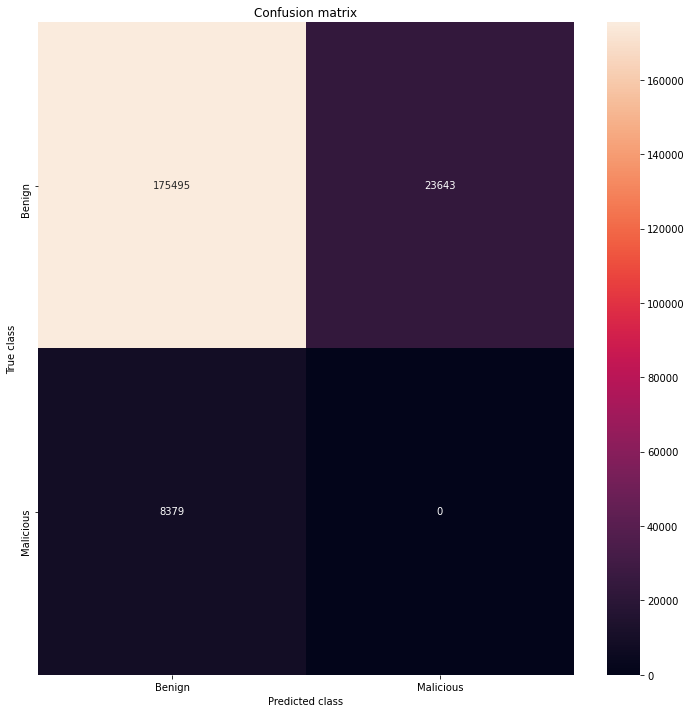

In [39]:
LABELS = ["Benign", "Malicious"]
y_pred = [1 if e > threshold else 0 for e in reconstruction_error.reconstruction_error.values]
conf_matrix = confusion_matrix(reconstruction_error.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [41]:
TP = conf_matrix[0][0]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]
TN = conf_matrix[1][1]
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1 = (2 * Precision * Recall) / (Precision + Recall)
Accuracy = (TP+TN)/(TP+FP+FN+TN)

print("TP: You predicted benign and its benign")
print("TN: You predicted malicious and its malicious")
print("FP: You predicted benign and its malicious")
print("FN: You predicted malicious and its benign")

print("\n\nImportant evaluation metrics:")
print("Recall score: " + str(Recall))
print("Recall: Recall tells us how many of the actual positive cases we were able to predict correctly with our model.")
print("Recall is a useful metric in cases where False Negative trumps False Positive.")
print("\nPrecision score: " + str(Precision))
print("Precision: Precision tells us how many of the correctly predicted cases actually turned out to be positive.")
print("Precision is a useful metric in cases where False Positive is a higher concern than False Negatives.")
print("\nF1 score: " + str(F1))
print("F1: F1-score is a harmonic mean (numerical average) of Precision and Recall. ")
print("If the interpretability of the F1-score is poor. This means that we don’t know what our classifier is maximizing – precision or recall?")
print("\nAccuracy score: " + str(Accuracy))
Image(url= "https://miro.medium.com/max/445/1*Z54JgbS4DUwWSknhDCvNTQ.png")

TP: You predicted benign and its benign
TN: You predicted malicious and its malicious
FP: You predicted benign and its malicious
FN: You predicted malicious and its benign


Important evaluation metrics:
Recall score: 0.9544307514928702
Recall: Recall tells us how many of the actual positive cases we were able to predict correctly with our model.
Recall is a useful metric in cases where False Negative trumps False Positive.

Precision score: 0.8812732878707228
Precision: Precision tells us how many of the correctly predicted cases actually turned out to be positive.
Precision is a useful metric in cases where False Positive is a higher concern than False Negatives.

F1 score: 0.9163942644094701
F1: F1-score is a harmonic mean (numerical average) of Precision and Recall. 
If the interpretability of the F1-score is poor. This means that we don’t know what our classifier is maximizing – precision or recall?

Accuracy score: 0.8456897507192181
